<a href="https://colab.research.google.com/github/jennynunez/032-DATA/blob/main/EDACheckpointGroup032_Wi22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 108 - EDA Checkpoint

# Names

*   Naval Patel
*   Ray Zhou
*   Nathaniel Satriya
*   Yoomin Oh
*   Jennifer Nunez


<a id='research_question'></a>
# Research Question

Is there a correlation between population density (people per square mile) and depression per capita and square mile in the State of California between the years 2000-2020?



# Dataset(s)

1. Dataset name: Historical Population Density Data (1910-2020)

*   Link: https://www.census.gov/data/tables/time-series/dec/density-data-text.html
*   Number of Observations: 684
*  This data provides the changing resident populations of each state in the US over 12 decades and ranks them based on their population density. Density is measured as the average population per square mile. According to the US Census Bureau, density levels have been higher across the Eastern sea and pacific coastline and lower in most of the West.


2. Dataset name: County Population Totals: 2010-2019 (California) 
*   Link: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html
*   Number of Observations: 58
* This provides the annual population estimates for each county in California from 2010 to 2019.


3. Dataset name: California Individuals by mental health diagnosis, gender, age, race, ethnicity and veteran status: Number, 2014-2019
*  Link:https://www.samhsa.gov/data/sites/default/files/reports/rpt35253/MHCLD-2019-R-FINAL.pdf
*   Number of Observations: 10
* This table was pulled from the 2019 Mental Health Client-Level Data (MH-CLD) Annual Report by SAMHSA, the agency within the U.S Department of Health and Human Services. Specifically, it provides information reported from state administrative data systems on: mental health diagnoses, mental health treatment settings, and demographic and substance use characteristics of individuals in mental health treatment facillities. Since our state of interest is California we pulled a relevant table from this report.

4. Dataset name: Diagnosed Depression (Ever) in LA county
* Link:http://publichealth.lacounty.gov/ha/HA_DATA_TRENDS.htm
* Number of Observations: 27
* This dataset provides estimates of depression diagnoses in health districts part of Los Angeles county jurisdiction, from 1999 to 2018. It contains other information about race, ethnicity, age group, poverty level, gender and education. The county of LA notes: "We are happy to provide the following data from the 2018 Los Angeles County Health Survey. Please note that the disparities seen in the results for the different groups shown in the table are to a large degree driven by inequities in the social, economic, and environmental conditions experienced by these groups."

5. Dataset name: 
General Population Cities & Unincorporated Communities
Los Angeles County (1990 through 2020 Census)
* Link: http://www.laalmanac.com/population/po03.php
* Number of Observations: 142
* Population estimates for cities in LA county sourced from Census data.

# Setup

In [42]:
# importing libraries
import pandas as pd
import numpy as np
import io
import csv
# from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from functools import reduce
from  matplotlib.ticker import FuncFormatter
from scipy import stats
import pdfplumber as pp

# Data Cleaning

* Every dataset was standardized to be lowercase, stripped of whitespace and punctuation, and drop empty values. This will make methods and operations function smoothly.

In [29]:
# Standardization functions
def remove_comma(output):
  if "," in output:
    output = output.replace(',', '')   
  return output

def remove_period(str_in):
  output = str_in
  try:
    output = str_in.lower()
    output = output.replace('.', '')
  except:
    output = str_in
    print("error")
  return output

def remove_dash(output):
  if "-" in output:
    output = output.replace('-','')
  return output

def remove_asterik(output):
  if "*" in output:
    output = output.replace('*', '')  
  return output

def remove_date(astr):
  return int(astr.replace("-01-01 00:00:00",""))

* Census data was fairly tidy already, but it included a lot of unecessary variables, so we filtered everything to focus on California observations starting from the years 2000 and forward.

* To narrow our focus we decided to extract California population counts and estimates. We will use this dataset to compare California mental health case estimates over the years 2000 to 2020.

In [30]:
# reading Historical Population Density Data (1910-2020) data from github 

population_url = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/apportionment.csv'
df1 = pd.read_csv(population_url)   # Original shape of this data, starting from 1910, is (684,10)                                   

# Drop all years except for 2000-2020
pop = df1.loc[(df1['Year'] >= 2000)]
#pop.shape                                        # After filtering it to only contain the 2000s the shape is (171,10)

# Focus on states and drop observations with Regions & Nations 
population = pop[pop['Geography Type'].str.contains("State")]

# Create a dataframe that focuses on the states & rename 'Geography Type' column to 'State'
population = population.rename(columns={'Name': 'name', 'Geography Type':'state', 'Year': 'year', 'Resident Population': 'res_pop_count', 'Percent Change in Resident Population': 'perc_change_res_pop', 'Resident Population Density': 'res_pop_density', 'Resident Population Density Rank': 'res_pop_density_rank'})
population = population.drop(population.columns[7:10], axis=1)
population = population.replace(',', '', regex=True)
population = population.astype({"res_pop_count": int, "perc_change_res_pop": float, "res_pop_density": float, "res_pop_density_rank": float})
# Filtered all states except California
population = population[population.name == 'California']
population = population.reset_index(drop=True)
population['state'] = population['state'].str.lower()
population['name'] = population['name'].str.lower()
population.head()


,name,state,year,res_pop_count,perc_change_res_pop,res_pop_density,res_pop_density_rank
0,california,state,2000,33871648,13.8,217.4,14.0
1,california,state,2010,37253956,10.0,239.1,13.0
2,california,state,2020,39538223,6.1,253.7,13.0


* The counties dataset needed all of its columns to be renamed to their respective variables.
* Initially we aimed to work with all counties in California, but based on available data we narrowed our scope to Los Angeles County. 

In [31]:
# California counties population totals fro 2010-2019
counties_url = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/CA_counties_pop.csv'
df3 = pd.read_csv(counties_url)
df3 = df3.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)': 'county',
                          'Unnamed: 1':'census', 'Unnamed: 2': 'estimates',
                          'Unnamed: 3': '2010',
                          'Unnamed: 4': '2011',
                          'Unnamed: 5': '2012',
                          'Unnamed: 6': '2013', 'Unnamed: 7': '2014',
                          'Unnamed: 8': '2015', 'Unnamed: 9': '2016',
                          'Unnamed: 10': '2017', 'Unnamed: 11': '2018',
                          'Unnamed: 12': '2019'})
# drop unneeded rows
df3 = df3.drop(labels=[0, 1, 2, 62, 63, 64, 65, 66], axis=0,).reset_index(drop=True)
# standardize county names to lowercase and remove unecessary punctuations
df3['county'] = df3['county'].apply(remove_period)
#Remove state
df3['county'] = df3['county'].apply(lambda str_in: str_in.replace(', california', ''))
#Remove commas
df3 = df3.applymap(lambda str_in: str_in.replace(',', '')).drop(labels = 0, axis=0)
#iterate remove_comma function to columns
temp = [str(2010 + i) for i in range(10)]
df3[temp] = df3[temp].apply(remove_comma)
df3[['census', 'estimates']] = df3[['census', 'estimates']].apply(remove_comma)
# store la county information in its own variable
la = df3.loc[df3['county'] == 'los angeles county']
la

,county,census,estimates,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
19,los angeles county,9818605,9819968,9823246,9876482,9935375,9992484,10040072,10085416,10105708,10103711,10073906,10039107


* Mental health data for the state of California was extracted from SAMHSA report and rewritten as a csv file using the tabulate method. 
* Columns were renamed for better understandability and values were standardized.

In [32]:
from pandas.core.arrays import string_
# California individuals counted by type of mental health diagnosis through the years 2014-2019

cm_to_pdf = 28.28                          # Converts our margin measurements from cm to pdf points
box  = [b * cm_to_pdf for b in [1,2,7,9]]                            # Table measurements from PDF document [top, left, bottom, width]
mh_url = 'https://www.samhsa.gov/data/sites/default/files/reports/rpt35253/MHCLD-2019-R-FINAL.pdf'
# df2 = tabula.read_pdf(mh_url, pages='438') # Using tabulate to read pdf

# *Convert this tabulated data to CSV (This portion will be commented out for faster shell processing)
# tabula.convert_into(mh_url, "mh.csv", pages="438", output_format="csv", stream=True)
# !cat mh.csv 

mh_url2 = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/mh.csv'
df2 = pd.read_csv(mh_url2)

# rename columns
df2 = df2.rename(columns={'Selected characteristics': 'disorder_type',
                          'Unnamed: 1':'totals', '2014': '2014',
                          '2015': '2015', '2016': '2016',
                          '2017': '2017', '2018': '2018',
                          '2019': '2019'})

# Copy disorder types to new dataframe
mh_disorders = df2.iloc[0:13, :]

# Make gender into its own df  *may delete
mh_genders = df2.iloc[13:17, :] 

# Make age its own df *may delete
mh_ages = df2.iloc[18:33, :]

# Clean NaN values for disorder types df
mh_disorders = mh_disorders.drop('totals',1)
mh_disorders = mh_disorders.dropna(axis=0)
mh_disorders = mh_disorders.reset_index(drop=True)

#iterate remove_comma function to columns
for i in range(0,6):
  temp = 2014 + i
  temp = str(temp)
  mh_disorders[temp] = mh_disorders[temp].apply(remove_comma)

def remove_dash(output):
  if "-" in output:
    output = output.replace('-','')
  return output

mh_disorders['disorder_type'] = mh_disorders['disorder_type'].str.lower()
mh_disorders['disorder_type'] = mh_disorders['disorder_type'].apply(remove_dash)

mh_disorders
# Move totals to bottom


,disorder_type,2014,2015,2016,2017,2018,2019
0,total individuals,697180,695815,647328,638394,708521,742725
1,trauma and stressorrelated disorders,107725,111807,105263,95751,110463,119469
2,anxiety disorders,75243,82479,81052,89225,109679,114954
3,attention deficit/hyperactivity disorder,52189,51489,47165,46369,49613,48632
4,mood disorders,308348,309996,271061,196965,243123,261427
5,bipolar disorders,113612,112390,99012,51718,60772,62227
6,depressive disorders,196785,199698,173975,146363,183711,200791
7,personality disorders,24234,23816,21994,14570,12654,10520
8,psychotic disorders,126411,126516,116156,116861,137630,137726
9,alcohol or substancerelated disorders,113129,112757,92537,64358,70782,68319


* Irrelevant information was removed and columns were renamed for better understanding.
* Standardized and converted to numerical values

In [33]:
# Los Angeles mental health data 
la_url = 'https://raw.githubusercontent.com/jennynunez/032-DATA/main/la_demos_cleaned.csv'
df4 = pd.read_csv(la_url, index_col=0)
# We want to drop the index name because it is not useful
df4.index.name = None
# We will now reset the index column and removing unhelpful values
df4 = df4.T.reset_index().reset_index(drop=True)
# Renaming columns that have incorrect labels
df4 = df4.rename(columns={'index': 'year'})
# Removing percentage symbol throughout the DataFrame
df4 = df4.replace('%', '', regex=True)
# Convering DataFrame to numeric values
df4 = df4.apply(pd.to_numeric)
# Properly formatting years in datetime format so Seaborn doesn't convert the years to floats
df4['year'] = pd.to_datetime(df4.year.astype(str), format="%Y")
# Renaming 'LA Overall' column to be more descriptive about what the data is telling us
overall = df4.rename(columns={'LA Overall': 'population_depression_diagnosis_percent'})
# The overall LA county data is in the first few rows so we are using a subset of the data
overall = overall.iloc[:, 0:2]
df4


,year,LA Overall,Alhambra,Antelope Valley,Bellflower,Central,Compton,East LA,East Valley,El Monte,...,Pomona,San Antonio,San Fernando,South,Southeast,Southwest,Torrance,West,West Valley,Whittier
0,2018-01-01,16.5,11.2,18.4,18.2,13.9,15.5,12.5,14.0,14.6,...,10.9,21.5,15.7,13.1,14.5,19.7,19.9,23.0,15.8,13.2
1,2015-01-01,13.0,9.7,19.2,13.8,20.0,12.2,12.4,13.5,6.2,...,10.2,11.6,14.6,14.8,12.0,10.3,11.6,15.2,10.8,12.7
2,2011-01-01,12.2,7.1,14.6,12.8,10.6,10.1,16.3,11.9,5.4,...,14.9,8.6,13.7,16.3,9.5,9.4,9.6,13.4,12.8,11.4
3,2007-01-01,13.6,9.1,17.1,10.7,15.4,12.7,15.2,13.6,12.3,...,14.2,14.2,11.2,12.8,18.7,12.4,13.7,13.2,12.4,14.5
4,2005-01-01,12.9,10.2,15.7,11.3,13.0,13.2,16.6,13.9,14.2,...,9.7,11.4,10.7,16.8,6.9,11.7,10.5,16.6,14.0,15.3
5,2002-01-01,9.7,8.3,9.2,8.8,8.8,5.4,8.1,12.4,5.4,...,8.6,9.5,8.9,6.7,10.1,7.1,10.4,11.7,11.2,12.0
6,1999-01-01,8.8,5.7,9.7,7.0,9.2,4.8,9.0,8.5,5.7,...,6.7,9.2,5.7,8.9,6.2,7.9,10.0,8.8,13.0,9.7


* For LA cities populations (based on their zipcode), we scraped a web page that compiled a table sourced from the Census Bureau data. This required reading in the data with the BeautifulSoup and requests libraries in order to create a clean pandas dataframe.
* Filtered to only include cities existing from 1990 and onwards, since our mental health data consists of these cities
* Standardized using previously made functions
* All estimates made numeric
* Combined with LA mental health data

In [34]:
# Cities in LA county populations
# First use BeautifulSoup to scrape the table data and convert to pandas dataframe
la_pop_url = 'http://www.laalmanac.com/population/po03.php'
r = requests.get(la_pop_url)
soup = BeautifulSoup(r.content, 'lxml')
table = soup.find_all('table')[0]
# remove multi-headers and set relevant column names
df5 = pd.read_html(str(table), header=None)[0]
df5.columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990']

# For newer cities that didn't exist in 1990, we'll remove values that appear as "---(2)"
df5 = df5[(df5['pop_2000'] != "---(2)")]
df5 = df5[(df5['pop_1990'] != "---(3)")] # reduced size to 129 cities
df5 = df5.reset_index(drop=True)


# Standardize to remove " * or - " and make cities lowercase
def remove_asterik(output):
  if "*" in output:
    output = output.replace('*', '')  
  return output
df5['city'] = df5['city'].apply(remove_asterik)
df5['city'] = df5['city'].str.lower()
df5['city'] = df5['city'].apply(remove_dash)
# Make all estimates numeric
df5[['pop_2020', 'pop_2010', 'pop_2000', 'pop_1990']] = df5[['pop_2020', 'pop_2010', 'pop_2000', 'pop_1990']].apply(pd.to_numeric)

# Now we want to filter only the cities that are also recorded from our mental health dataset
# First flip df4 using transpose so cities are row indexes
flipped = df4.transpose()
flipped = flipped.reset_index()
flipped = flipped.iloc[1: , :]
flipped.columns = ['city','mh_2018', 'mh_2015', 'mh_2011', 'mh_2007', 'mh_2005', 'mh_2002', 'mh_1999']
flipped['city'] = flipped['city'].str.lower()
flipped[['mh_2018', 'mh_2015', 'mh_2011', 'mh_2007', 'mh_2005', 'mh_2002', 'mh_1999']] = flipped[['mh_2018', 'mh_2015', 'mh_2011', 'mh_2007', 'mh_2005', 'mh_2002', 'mh_1999']].apply(pd.to_numeric)
# Merge once all values have been made numeric, and city names have been standardized
# Trying merge them together with reduce method 
# df6 = reduce(lambda l, r: pd.merge(flipped, df5, on='city', how='inner'), df5)
# This method brings 11 out of 26 cities we're looking for

# Some missing cities are included but as a different label in df5. Once we identify the missing cities, we'll manually extract, and append to:
missing = pd.DataFrame()
# To see whole table and identify cities:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
#print(la_mh)

# Antelope Valley mental health cases comprise of 5 cities. We will make a new df with Antelope Valley cities, then sum and reassign these values to this city.
# Antelope Valley (includes 'acton', 'palmdale', 'lancaster', 'lake los angeles', 'quartz hill')
ant_v = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
ant_v = ant_v.append({'city':'acton', 'pop_2020':7431,'pop_2010':7596, 'pop_2000':2390, 'pop_1990':1471}, ignore_index=True)
ant_v = ant_v.append({'city':'palmdale', 'pop_2020':169450,'pop_2010':152750, 'pop_2000':116670, 'pop_1990':68842}, ignore_index=True)
ant_v = ant_v.append({'city':'lancaster', 'pop_2020':173516,'pop_2010':156633, 'pop_2000':118718, 'pop_1990':97291}, ignore_index=True)
ant_v = ant_v.append({'city':'lancaster', 'pop_2020':13187,'pop_2010':12328, 'pop_2000':11523, 'pop_1990':7977}, ignore_index=True)
ant_v = ant_v.append({'city':'quartz hill', 'pop_2020':11447,'pop_2010':10912, 'pop_2000':9890, 'pop_1990':9626}, ignore_index=True)
ant_v = ant_v.set_index('city')
# Now that Antelope Valley's cities are in dataframe, we sum value of columns, and assign values to the missing dataframe
t1 = ant_v.sum()
t1.name = 'antelope valley'
ant_v = ant_v.append(t1) # assigning totals to a row
missing = missing.append({'city':'antelope valley', 'pop_2020':375031,'pop_2010':340219, 'pop_2000':259191, 'pop_1990':185207}, ignore_index=True)
# Now we will do the same for ALL missing cities (East LA, East Valley, Foothill, Harbor, Hollywood/Wilshire, Northeast, San Antonio, South, Southeast, Southwest, west, west valley)

# East LA (includes: 'east los angeles')
ela = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
ela = ela.append({'city':'east los angeles', 'pop_2020':118786,'pop_2010':126496, 'pop_2000':124283, 'pop_1990':126379}, ignore_index=True)
missing = missing.append({'city':'east la', 'pop_2020':118786,'pop_2010':126496, 'pop_2000':124283, 'pop_1990':126379}, ignore_index=True)

# East Valley (includes: 'san fernando','burbank', 'hidden hills')
eva = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
eva = eva.append({'city':'san fernando', 'pop_2020':23946,'pop_2010':23645, 'pop_2000':23564, 'pop_1990':22580}, ignore_index=True)
eva = eva.append({'city':'san fernando', 'pop_2020':107337,'pop_2010':103340, 'pop_2000':100316, 'pop_1990':93643}, ignore_index=True)
eva = eva.append({'city':'hidden hills', 'pop_2020':1725,'pop_2010':1856, 'pop_2000':1875, 'pop_1990':1729}, ignore_index=True)
eva = eva.set_index('city')
t2 = eva.sum()
t2.name = 'east valley'
eva = eva.append(t2)
missing = missing.append({'city':'east valley', 'pop_2020':133008,'pop_2010':128841, 'pop_2000':125755, 'pop_1990':117952},ignore_index=True)

# Foothills (includes: 'san gabirel', 'south san gabriel','east san gabriel', 'south pasadena', 'san marino','east pasadena', 'sierra madre', 'glendora',
# 'san dimas', 'covina','west covina','charter oak', 'walnut', 'la puente', 'valinda', 'vincent', 'monterey park','rosemead','temple city', 'hacienda heights'
# 'rowland heights', 'citrus', 'south el monte', 'avocado heights', 'baldwin park','south san jose hills')
f = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
f = f.append({'city':'san gabriel', 'pop_2020':39568,'pop_2010':39718, 'pop_2000':39804, 'pop_1990':37120}, ignore_index=True)
f = f.append({'city':'south san gabriel', 'pop_2020':7920,'pop_2010':8070, 'pop_2000':7595, 'pop_1990':7700}, ignore_index=True)
f = f.append({'city':'east san gabriel', 'pop_2020':22769,'pop_2010':14874, 'pop_2000':14512, 'pop_1990':12736}, ignore_index=True)
f = f.append({'city':'south pasadena', 'pop_2020':26943,'pop_2010':25619, 'pop_2000':24292, 'pop_1990':23936}, ignore_index=True)
f = f.append({'city':'san marino', 'pop_2020':12513,'pop_2010':13147, 'pop_2000':12945, 'pop_1990':12959}, ignore_index=True)
f = f.append({'city':'east pasadena', 'pop_2020':6021,'pop_2010':6144, 'pop_2000':6045, 'pop_1990':5910}, ignore_index=True)
f = f.append({'city':'sierra madre', 'pop_2020':11268,'pop_2010':10917, 'pop_2000':10578, 'pop_1990':10762}, ignore_index=True)
f = f.append({'city':'glendora', 'pop_2020':52558,'pop_2010':50073, 'pop_2000':49415, 'pop_1990':47828}, ignore_index=True)
f = f.append({'city':'san dimas', 'pop_2020':34924,'pop_2010':33371, 'pop_2000':34980, 'pop_1990':32397}, ignore_index=True)
f = f.append({'city':'covina', 'pop_2020':51268,'pop_2010':47796, 'pop_2000':46837, 'pop_1990':43207}, ignore_index=True)
f = f.append({'city':'west covina', 'pop_2020':109501,'pop_2010':106098, 'pop_2000':105080, 'pop_1990':96086}, ignore_index=True)
f = f.append({'city':'charter oak', 'pop_2020':9739,'pop_2010':9310, 'pop_2000':9027, 'pop_1990':8858}, ignore_index=True)
f = f.append({'city':'walnut', 'pop_2020':28430,'pop_2010':29172, 'pop_2000':30004, 'pop_1990':29105}, ignore_index=True)
f = f.append({'city':'la puente', 'pop_2020':38062,'pop_2010':39816, 'pop_2000':41063, 'pop_1990':36955}, ignore_index=True)
f = f.append({'city':'valinda', 'pop_2020':22437,'pop_2010':22822, 'pop_2000':46837, 'pop_1990':18735}, ignore_index=True)
f = f.append({'city':'vincent', 'pop_2020':15714,'pop_2010':15922, 'pop_2000':15097, 'pop_1990':13713}, ignore_index=True)
f = f.append({'city':'monterey park', 'pop_2020':61096,'pop_2010':60269, 'pop_2000':60051, 'pop_1990':60738}, ignore_index=True)
f = f.append({'city':'rosemead', 'pop_2020':51185,'pop_2010':53764, 'pop_2000':53505, 'pop_1990':51638}, ignore_index=True)
f = f.append({'city':'temple city', 'pop_2020':36494,'pop_2010':35558, 'pop_2000':33377, 'pop_1990':31100}, ignore_index=True)
f = f.append({'city':'hacienda heights', 'pop_2020':54191,'pop_2010':54038, 'pop_2000':53122, 'pop_1990':52354}, ignore_index=True)
f = f.append({'city':'rowland heights', 'pop_2020':54191,'pop_2010':54038, 'pop_2000':53122, 'pop_1990':52354}, ignore_index=True)
f = f.append({'city':'citrus', 'pop_2020':10243,'pop_2010':10866, 'pop_2000':10581, 'pop_1990':9481}, ignore_index=True)
f = f.append({'city':'south el monte', 'pop_2020':19567,'pop_2010':20116, 'pop_2000':21144, 'pop_1990':20850}, ignore_index=True)
f = f.append({'city':'avocado heights', 'pop_2020':13317,'pop_2010':15411, 'pop_2000':15148, 'pop_1990':14232}, ignore_index=True)
f = f.append({'city':'baldwin park', 'pop_2020':72176,'pop_2010':75390, 'pop_2000':75837, 'pop_1990':69330}, ignore_index=True)
f = f.append({'city':'south san jose hills', 'pop_2020':19855,'pop_2010':20551, 'pop_2000':20218, 'pop_1990':17814}, ignore_index=True)
f = f.set_index('city')
t3 = f.sum()
t3.name = 'foothill'
f = f.append(t3)
missing = missing.append({'city':'foothill', 'pop_2020':881950,'pop_2010':872870, 'pop_2000':890216, 'pop_1990':817898},ignore_index=True)

# Harbor (includes: 'carson','west carson', 'long beach', 'lakewood','hawaiian gardens', 'signal hill')
h = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
h = h.append({'city':'carson', 'pop_2020':95558,'pop_2010':91714, 'pop_2000':89730, 'pop_1990':83995}, ignore_index=True)
h = h.append({'city':'west carson', 'pop_2020':22870,'pop_2010':21699, 'pop_2000':21138, 'pop_1990':20143}, ignore_index=True)
h = h.append({'city':'long beach', 'pop_2020':466742,'pop_2010':462257, 'pop_2000':461522, 'pop_1990':429433}, ignore_index=True)
h = h.append({'city':'lakewood', 'pop_2020':82496,'pop_2010':80048, 'pop_2000':79345, 'pop_1990':73557}, ignore_index=True)
h = h.append({'city':'hawaiian gardens', 'pop_2020':14149,'pop_2010':14254, 'pop_2000':14779, 'pop_1990':13639}, ignore_index=True)
h = h.append({'city':'signal hill', 'pop_2020':11848,'pop_2010':11016, 'pop_2000':9333, 'pop_1990':8371}, ignore_index=True)
h = h.set_index('city')
t4 = h.sum()
t4.name = 'harbor'
h = h.append(t4)
missing = missing.append({'city':'harbor', 'pop_2020':693663,'pop_2010':680988, 'pop_2000':675847, 'pop_1990':629138},ignore_index=True)

# West (include: 'west hollywood', 'beverly hills', 'santa monica', 'ladera heights', 'marina del rey','culver city',)
w = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
w = w.append({'city':'west hollywood', 'pop_2020':35757,'pop_2010':34399, 'pop_2000':35716, 'pop_1990':36118}, ignore_index=True)
w = w.append({'city':'beverly hills', 'pop_2020':32701,'pop_2010':34109, 'pop_2000':33784, 'pop_1990':31971}, ignore_index=True)
w = w.append({'city':'santa monica', 'pop_2020':93076,'pop_2010':89736, 'pop_2000':84084, 'pop_1990':86905}, ignore_index=True)
w = w.append({'city':'ladera heights', 'pop_2020':6654,'pop_2010':6498, 'pop_2000':6568, 'pop_1990':6316}, ignore_index=True)
w = w.append({'city':'marina del rey', 'pop_2020':11373,'pop_2010':8866, 'pop_2000':8176, 'pop_1990':7431}, ignore_index=True)
w = w.append({'city':'culver city', 'pop_2020':40779,'pop_2010':38883, 'pop_2000':38816, 'pop_1990':38793}, ignore_index=True)
w = w.set_index('city')
t5 = w.sum()
t5.name = 'west'
w = w.append(t5)
missing = missing.append({'city':'west', 'pop_2020':220340,'pop_2010':212491, 'pop_2000':207144, 'pop_1990':207534},ignore_index=True)

# South (includes: 'view park windsor hills', 'westmont','west athens', 'willowbrook','florencegraham')
s = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
s = s.append({'city':'view park windsor hills', 'pop_2020':11419,'pop_2010':11075, 'pop_2000':10958, 'pop_1990':11769}, ignore_index=True)
s = s.append({'city':'westmont', 'pop_2020':33913,'pop_2010':31853, 'pop_2000':31623, 'pop_1990':31044}, ignore_index=True)
s = s.append({'city':'west athens', 'pop_2020':9393,'pop_2010':8729, 'pop_2000':9101, 'pop_1990':8859}, ignore_index=True)
s = s.append({'city':'willowbrook', 'pop_2020':24295,'pop_2010':35983, 'pop_2000':34138, 'pop_1990':32772}, ignore_index=True)
s = s.append({'city':'florence graham', 'pop_2020':61983,'pop_2010':63387, 'pop_2000':60197, 'pop_1990':57147}, ignore_index=True)
s = s.set_index('city')
t6 = s.sum()
t6.name = 'south'
s = s.append(t6)
missing = missing.append({'city':'south', 'pop_2020':141003,'pop_2010':151027, 'pop_2000':146017, 'pop_1990':141591},ignore_index=True)

# Southeast (include:'artesia','vernon', 'bellflower','downey', 'south gate', 'bell','cudahy','bell gardens', 'huntington park',
# 'la mirada', 'santa fe springs','maywood','norwalk','paramount','south whittier', 'pico rivera','montebello','commerce','cerritos',
# 'east whitter (formerly east la mirada)'
se = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
se = se.append({'city':'artesia', 'pop_2020':16395,'pop_2010':16522, 'pop_2000':16380, 'pop_1990':15464}, ignore_index=True)
se = se.append({'city':'vernon', 'pop_2020':222,'pop_2010':112, 'pop_2000':91, 'pop_1990':152}, ignore_index=True)
se = se.append({'city':'bellflower', 'pop_2020':79190,'pop_2010':76616, 'pop_2000':72878, 'pop_1990':61815}, ignore_index=True)
se = se.append({'city':'downey', 'pop_2020':114355,'pop_2010':111772, 'pop_2000':107323, 'pop_1990':91444}, ignore_index=True)
se = se.append({'city':'south gate', 'pop_2020':92726,'pop_2010':94396, 'pop_2000':96375, 'pop_1990':86284}, ignore_index=True)
se = se.append({'city':'bell', 'pop_2020':33559,'pop_2010':35477, 'pop_2000':36664, 'pop_1990':34365}, ignore_index=True)
se = se.append({'city':'cudahy', 'pop_2020':22811,'pop_2010':23805, 'pop_2000':24208, 'pop_1990':22817}, ignore_index=True)
se = se.append({'city':'bell gardens', 'pop_2020':39501,'pop_2010':42072, 'pop_2000':44054, 'pop_1990':42355}, ignore_index=True)
se = se.append({'city':'huntington park', 'pop_2020':54883,'pop_2010':58114, 'pop_2000':61348, 'pop_1990':56065}, ignore_index=True)
se = se.append({'city':'la mirada', 'pop_2020':48008,'pop_2010':48527, 'pop_2000':46783, 'pop_1990':40452}, ignore_index=True)
se = se.append({'city':'santa fe springs', 'pop_2020':19219,'pop_2010':16223, 'pop_2000':17438, 'pop_1990':15520}, ignore_index=True)
se = se.append({'city':'maywood', 'pop_2020':25138,'pop_2010':27395, 'pop_2000':28083, 'pop_1990':27850	}, ignore_index=True)
se = se.append({'city':'norwalk', 'pop_2020':102773,'pop_2010':105549, 'pop_2000':103298, 'pop_1990':94279	}, ignore_index=True)
se = se.append({'city':'paramount', 'pop_2020':53733,'pop_2010':54098, 'pop_2000':55266, 'pop_1990':47669	}, ignore_index=True)
se = se.append({'city':'south whittier', 'pop_2020':56415,'pop_2010':57156, 'pop_2000':55193, 'pop_1990':49514	}, ignore_index=True)
se = se.append({'city':'pico rivera', 'pop_2020':62088,'pop_2010':62942, 'pop_2000':63428, 'pop_1990':59177	}, ignore_index=True)
se = se.append({'city':'montebello', 'pop_2020':62640,'pop_2010':62500, 'pop_2000':62150, 'pop_1990':59564	}, ignore_index=True)
se = se.append({'city':'commerce', 'pop_2020':12378,'pop_2010':12823, 'pop_2000':12568, 'pop_1990':12135	}, ignore_index=True)
se = se.append({'city':'cerritos', 'pop_2020':49578,'pop_2010':49041, 'pop_2000':51488, 'pop_1990':53240	}, ignore_index=True)
se = se.append({'city':'east whitter (formerly east la mirada)', 'pop_2020':10394,'pop_2010':9757, 'pop_2000':9538, 'pop_1990':9367	}, ignore_index=True)
se = se.set_index('city')
t7 = se.sum()
t7.name = 'southeast'
se = se.append(t7)
missing = missing.append({'city':'southeast', 'pop_2020':956006,'pop_2010':964897, 'pop_2000':964554, 'pop_1990':879528},ignore_index=True)

# Southwest (include:'manhattan beach','torrance','inglewood','gardena','lennox','el segundo','hawthorne','redondo beach','lawndale'
# 'hermosa beach','rolling hills estates','palo verde estates','rancho palos verdes','lomita','alondra park')
sw = pd.DataFrame(columns = ['city', 'pop_2020', 'pop_2010', 'pop_2000', 'pop_1990'])
sw = sw.append({'city':'manhattan beach', 'pop_2020':35506,'pop_2010':35135, 'pop_2000':33852, 'pop_1990':32063	}, ignore_index=True)
sw = sw.append({'city':'torrance', 'pop_2020':147067,'pop_2010':145438, 'pop_2000':137946, 'pop_1990':133107}, ignore_index=True)
sw = sw.append({'city':'inglewood', 'pop_2020':107762,'pop_2010':109673, 'pop_2000':112580, 'pop_1990':109602	}, ignore_index=True)
sw = sw.append({'city':'gardena', 'pop_2020':61027,'pop_2010':58829, 'pop_2000':57746, 'pop_1990':49847	}, ignore_index=True)
sw = sw.append({'city':'lennox', 'pop_2020':20323,'pop_2010':22753, 'pop_2000':22950, 'pop_1990':22757	}, ignore_index=True)
sw = sw.append({'city':'el segundo', 'pop_2020':17272,'pop_2010':16654, 'pop_2000':16033, 'pop_1990':15223	}, ignore_index=True)
sw = sw.append({'city':'hawthorne', 'pop_2020':88083,'pop_2010':84293, 'pop_2000':84112	, 'pop_1990':71349	}, ignore_index=True)
sw = sw.append({'city':'redondo beach', 'pop_2020':71576,'pop_2010':66748, 'pop_2000':63261, 'pop_1990':60167	}, ignore_index=True)
sw = sw.append({'city':'lawndale', 'pop_2020':31807,'pop_2010':32769, 'pop_2000':31711, 'pop_1990':27331	}, ignore_index=True)
sw = sw.append({'city':'hermosa beach', 'pop_2020':19728,'pop_2010':19506, 'pop_2000':18566, 'pop_1990':18219	}, ignore_index=True)
sw = sw.append({'city':'rolling hills estates', 'pop_2020':8280,'pop_2010':8067, 'pop_2000':7676, 'pop_1990':7789	}, ignore_index=True)
sw = sw.append({'city':'palos verdes estates', 'pop_2020':13347,'pop_2010':13438, 'pop_2000':13340, 'pop_1990':13512	}, ignore_index=True)
sw = sw.append({'city':'rancho palos verdes', 'pop_2020':42287,'pop_2010':41643, 'pop_2000':41145, 'pop_1990':41659	}, ignore_index=True)
sw = sw.append({'city':'lomita', 'pop_2020':20921,'pop_2010':20256, 'pop_2000':20046, 'pop_1990':19382	}, ignore_index=True)
sw = sw.append({'city':'alondra park', 'pop_2020':8569,'pop_2010':8592, 'pop_2000':8622, 'pop_1990':12215	}, ignore_index=True)
sw = sw.set_index('city')
t8 = sw.sum()
t8.name = 'southwest'
sw = sw.append(t8)
missing = missing.append({'city':'southwest', 'pop_2020':693555,'pop_2010':683794, 'pop_2000':669586, 'pop_1990':634222},ignore_index=True)

# Make all estimates numeric
missing[['pop_2020', 'pop_2010', 'pop_2000', 'pop_1990']] = missing[['pop_2020', 'pop_2010', 'pop_2000', 'pop_1990']].apply(pd.to_numeric)
# DROPPING: HOLLYWOOD/WILSHIRE, CENTRAL, WEST VALLEY, SAN ANTONIO, NORTHEAST (alternative is to find data from census through zipcodes)


* Now that the missing cities data has been found and placed in a dataframe, we can concatenate it to the dataframe with all of the cities population estimates (df5)
This updated list will be merged with the mental health cases per region (flipped). This combined dataset will be used to check if a relationship exists between mental health disorders and population density, and how that may have changed over the years.
* *Note that some of the regions were dropped during the merge because the data was limited, and there was insufficient information to include it. These regions were: Hollywood/Wilshire, Central, West Valley, San Antonio, Northeast

In [35]:
# Concatenate missing data to combined dataset
df5 = pd.concat([missing,df5])
df5 = df5.reset_index(drop=True)
# Merge at the end
df6 = reduce(lambda l, r: pd.merge(flipped, df5, on='city', how='inner'), df5)
df6

,city,mh_2018,mh_2015,mh_2011,mh_2007,mh_2005,mh_2002,mh_1999,pop_1990,pop_2000,pop_2010,pop_2020
0,alhambra,11.2,9.7,7.1,9.1,10.2,8.3,5.7,82106.0,85804.0,83089.0,82868.0
1,antelope valley,18.4,19.2,14.6,17.1,15.7,9.2,9.7,185207.0,259191.0,340219.0,375031.0
2,bellflower,18.2,13.8,12.8,10.7,11.3,8.8,7.0,61815.0,72878.0,76616.0,79190.0
3,compton,15.5,12.2,10.1,12.7,13.2,5.4,4.8,90454.0,93493.0,96455.0,95740.0
4,east la,12.5,12.4,16.3,15.2,16.6,8.1,9.0,126379.0,124283.0,126496.0,118786.0
5,east valley,14.0,13.5,11.9,13.6,13.9,12.4,8.5,117952.0,125755.0,128841.0,133008.0
6,el monte,14.6,6.2,5.4,12.3,14.2,5.4,5.7,106209.0,115965.0,113475.0,109450.0
7,foothill,14.1,12.5,13.7,12.4,11.1,11.7,10.9,817898.0,890216.0,872870.0,881950.0
8,glendale,19.3,12.1,19.2,18.2,11.5,7.9,8.2,180038.0,194973.0,191719.0,196543.0
9,harbor,24.5,12.1,14.5,11.8,13.0,4.1,4.1,629138.0,675847.0,680988.0,693663.0


# Data Analysis

[Text(0.5, 1.0, 'Percentage of Population with Depression in Los Angeles, CA'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Percent of LA Population with Depression')]

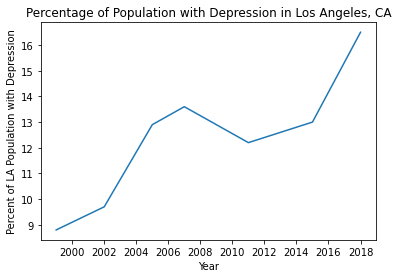

In [36]:
# Graphing Percentage of Population with Depression in Los Angeles, CA using Seaborn lineplot and renaming axes to be more descriptive
sns.lineplot(data=overall, x='year', y='population_depression_diagnosis_percent').set(title="Percentage of Population with Depression in Los Angeles, CA", xlabel="Year", ylabel="Percent of LA Population with Depression")

The figure above is a line chart displaying the percent of the population in Los Angeles, CA that has a diagnosis of depression in a particular year. Althhough there was a brief decline in the percent of the LA population diagnosed with depression between 2007 and 2011, the overall trend has been a significant overall increase from about 9% of the population in 2000 to over 16% of the population in 2018.

<Figure size 2880x2160 with 0 Axes>

Text(0, 0.5, 'Depression percentage in Antelope Valley')

Text(0, 0.5, 'Depression percentage in Bellflower')

Text(0, 0.5, 'Depression percentage in Central')

Text(0, 0.5, 'Depression percentage in Compton')

Text(0, 0.5, 'Depression percentage in East LA')

Text(0, 0.5, 'Depression percentage in East Valley')

Text(0, 0.5, 'Depression percentage in El Monte')

Text(0, 0.5, 'Depression percentage in Foothill')

Text(0, 0.5, 'Depression percentage in Glendale')

Text(0, 0.5, 'Depression percentage in Harbor')

Text(0, 0.5, 'Depression percentage in Hollywood/Wilshire')

Text(0, 0.5, 'Depression percentage in Inglewood')

Text(0, 0.5, 'Depression percentage in Long Beach')

Text(0, 0.5, 'Depression percentage in Northeast')

Text(0, 0.5, 'Depression percentage in Pasadena')

Text(0, 0.5, 'Depression percentage in Pomona')

Text(0, 0.5, 'Depression percentage in San Antonio')

Text(0, 0.5, 'Depression percentage in San Fernando')

Text(0, 0.5, 'Depression percentage in South')

Text(0, 0.5, 'Depression percentage in Southeast')

Text(0, 0.5, 'Depression percentage in Southwest')

Text(0, 0.5, 'Depression percentage in Torrance')

Text(0, 0.5, 'Depression percentage in West')

Text(0, 0.5, 'Depression percentage in West Valley')

Text(0, 0.5, 'Depression percentage in Whittier')

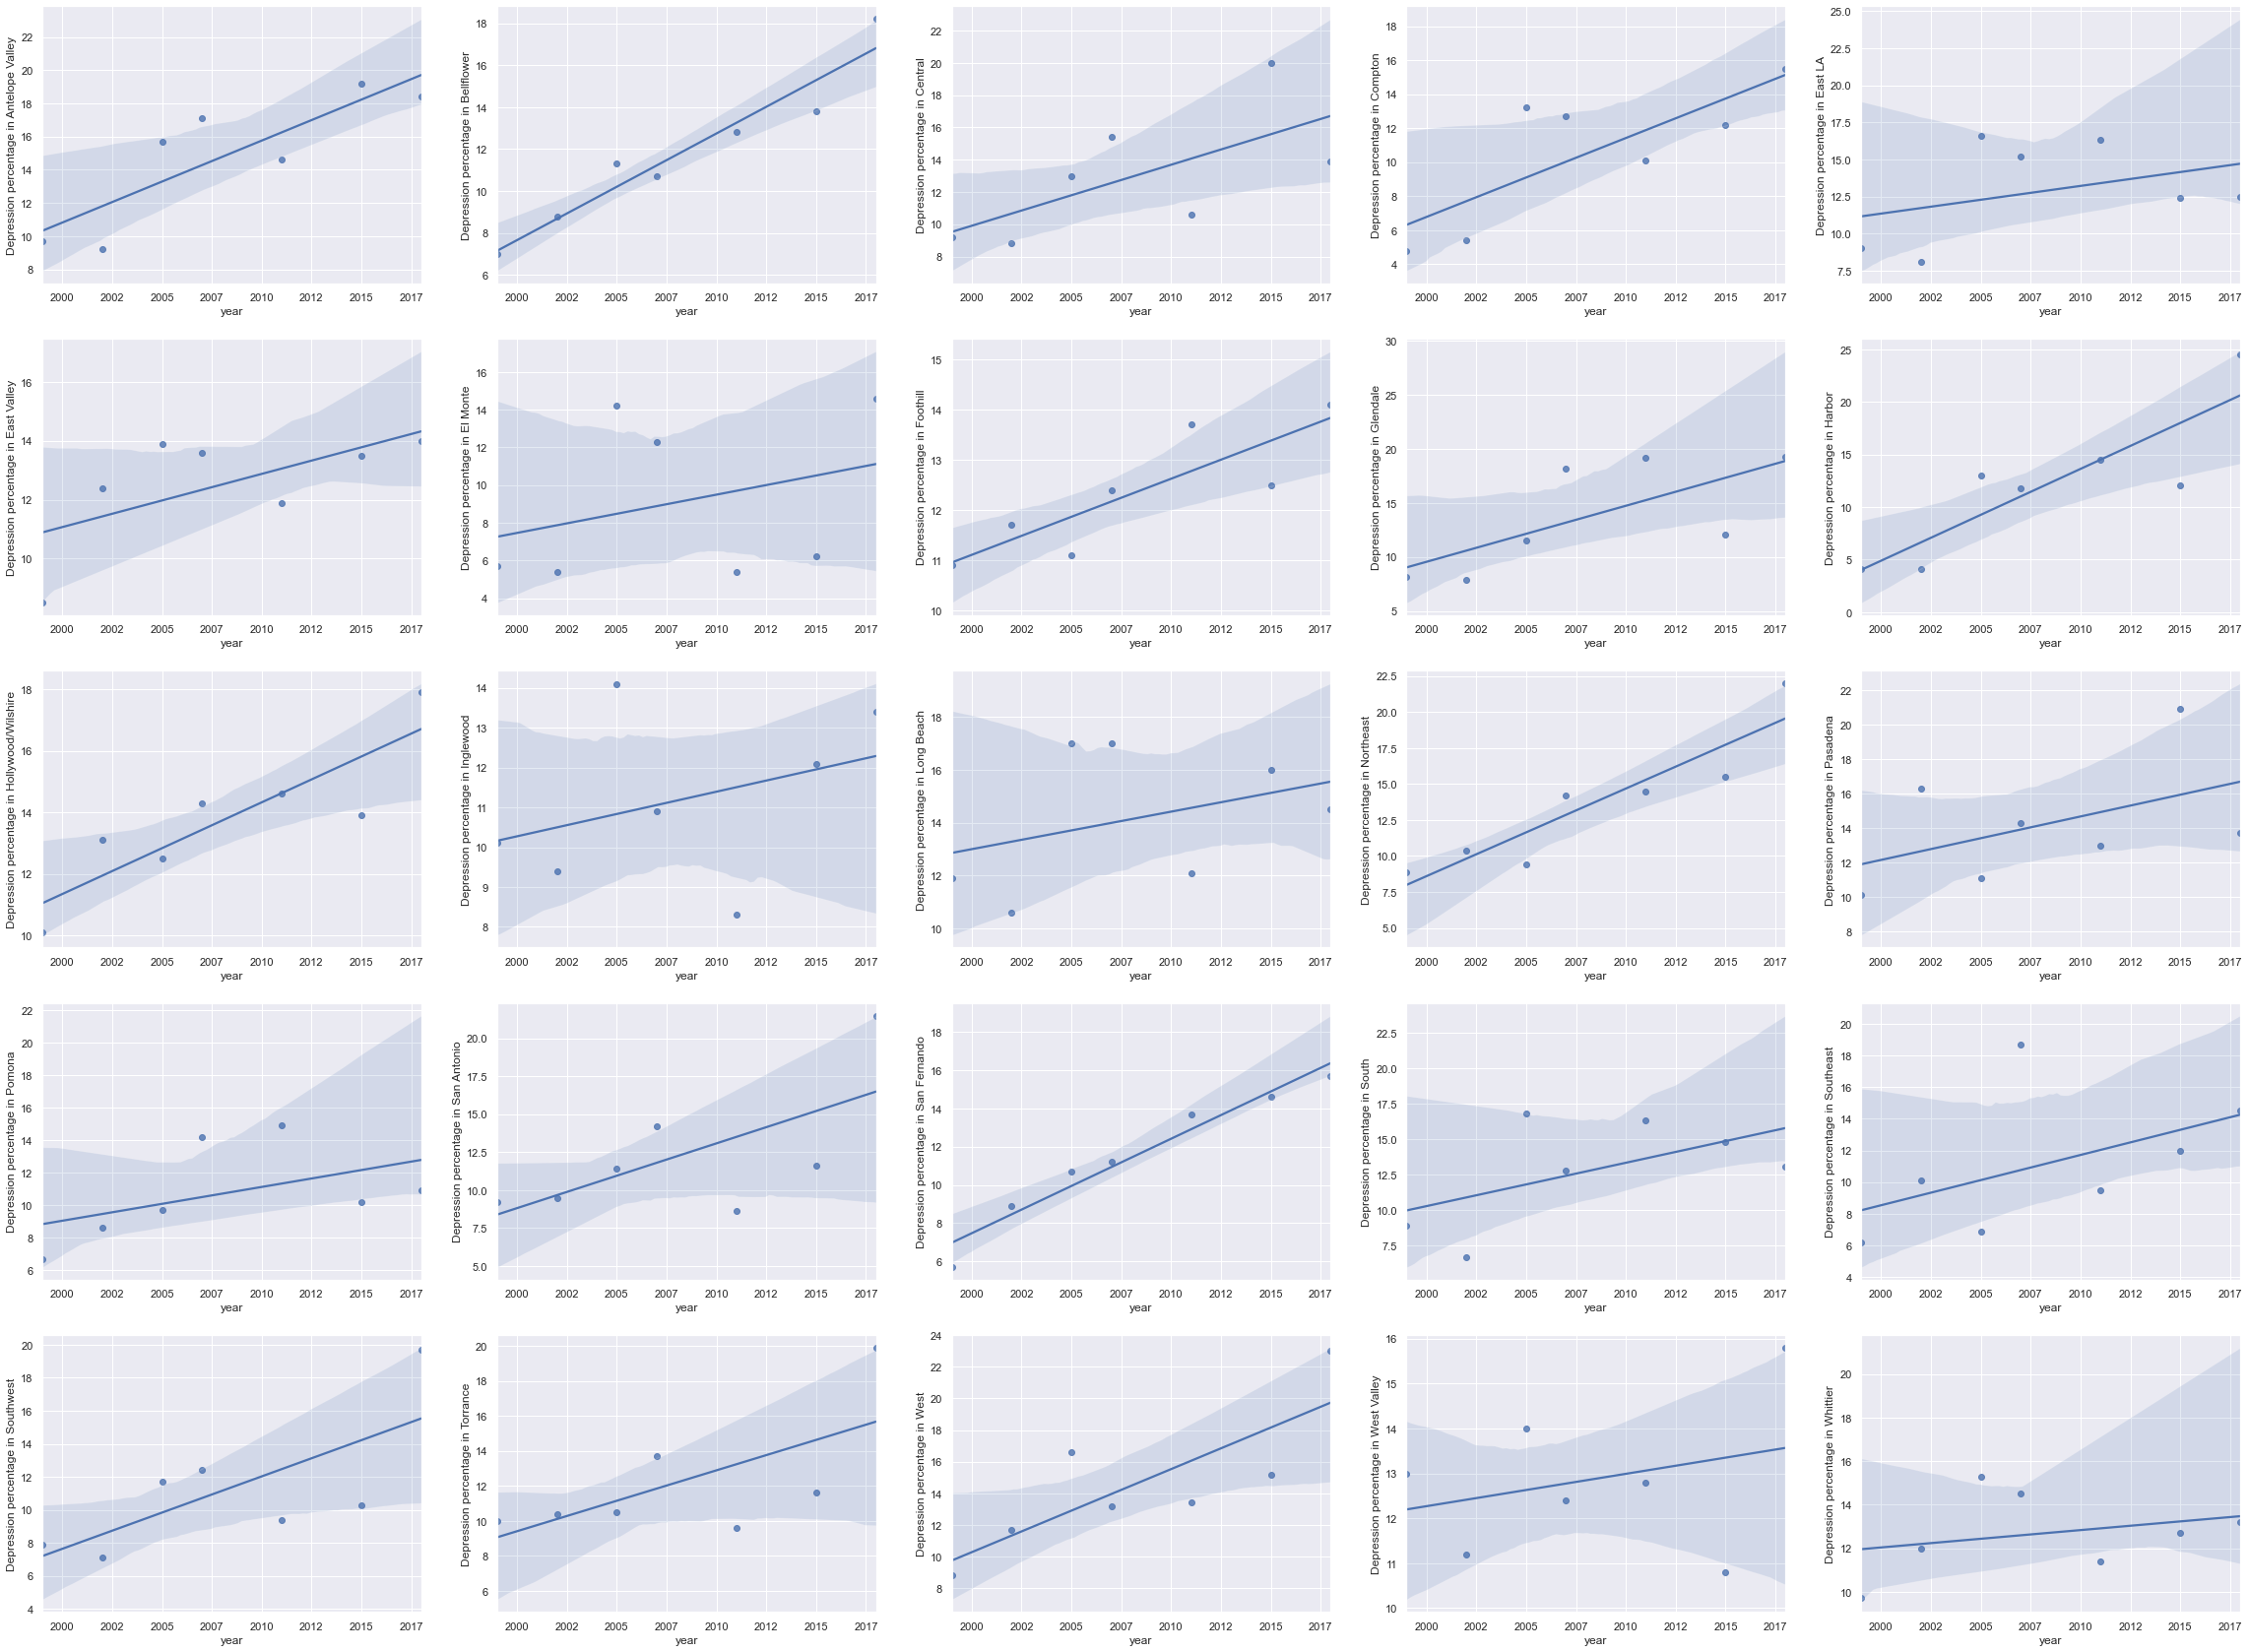

In [37]:
# potential to-dos:
# LINEAR REGRESSION ON POPULATION PER CITY X DEPRESSION RATES OF CITIES
# GRAPH LOS ANGELES POPULATION AS A WHOLE, BY THE SUM OF LA POPULATION DEPRESSION RATES

# check for california population density correlation to california mental health data sets as a whole?
 # then from here narrow into Los Angeles data
 # calculate population density of each city
 # compare density with depression

# FIX QUALITY OF GRAPHS / make bigger?
# CREATE MAP WITH LA CITIES AND CORRESPONDING DEPRESSION HOT SPOTS

def remove_date(astr):
  return int(astr.replace("-01-01 00:00:00",""))

##For fun????. Delete them if no need
df4_graph = df4.drop(columns = ['LA Overall'])

#Regression line for each city by time. 
df4_graph['year'] = df4_graph['year'].astype(object).astype(str).apply(remove_date)
sns.set(rc={'figure.figsize':(40,30)})
curr = 1;
plt.figure(0)
temp = df4_graph.iloc[:, 2:]
for i in temp:
  ax = plt.subplot(5, 5, curr)
  ax = sns.regplot(x="year", y= i , data = df4_graph);
  ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
  ax.set_ylabel("Depression percentage in " + i)
  curr = curr + 1
plt.show()


* The above figures show the regression lines for each of the LA cities with depression data. There appears to be a general positive relationship in all of LA cities depression cases, meaning they are increasing, with some being stronger than others. Bellflower, San Fernando and Northeast appear to have the strongest linear relationships with lower Standard Error, while Inglewood, El Monte, East LA and Southeast have weaker relationships and a higher Standard Error. 
* We will now compare these 

In [38]:


df7 = pd.DataFrame(np.array([[2018],[2015],[2011],[2007],[2005],[2002],[1999]]),columns=['year'])

for index, row  in df6.iterrows():
  city = row['city']
  mh_2018 = row['mh_2018']
  mh_2015 = row['mh_2015']
  mh_2011	= row['mh_2011']
  mh_2007= 	row['mh_2007']
  mh_2005	= row['mh_2005']
  mh_2002	= row['mh_2002']
  mh_1999	= row['mh_1999']
  #pop_2020=	row['pop_2020']
  #pop_2010=	row['pop_2010']
  #pop_2000=	row['pop_2000']
  #pop_1990=	row['pop_1990']

  #Getting regression line with current datas so that I can predict population in each city in the certain year
  y = [row['pop_2020'],row['pop_2010'],row['pop_2000'],row['pop_1990']]
  x = [2020,2010,2000,1990]
  slope, intercept, r, p, std_err = stats.linregress(x, y)

  pop_2018=	slope * 2018 + intercept
  pop_2015= slope * 2015 + intercept
  pop_2011=	slope * 2011 + intercept
  pop_2007=	slope * 2007 + intercept
  pop_2005	= slope * 2005 + intercept
  pop_2002	= slope * 2002 + intercept
  pop_1999	= slope * 1999 + intercept


  df7[city + "_Mh"] = [mh_2018,mh_2015,mh_2011,mh_2007 ,mh_2005,mh_2002,mh_1999 ]
  df7[city + "_pop"] = [pop_2018,pop_2015,pop_2011,pop_2007 ,pop_2005,pop_2002,pop_1999 ]



df7  
  

,year,alhambra_Mh,alhambra_pop,antelope valley_Mh,antelope valley_pop,bellflower_Mh,bellflower_pop,compton_Mh,compton_pop,east la_Mh,...,southeast_Mh,southeast_pop,southwest_Mh,southwest_pop,torrance_Mh,torrance_pop,west_Mh,west_pop,whittier_Mh,whittier_pop
0,2018,11.2,83410.98,18.4,374477.0,18.2,79886.94,15.5,96482.1,12.5,...,14.5,971117.26,19.7,695276.16,19.9,147307.86,23.0,217566.70,13.2,87469.28
1,2015,9.7,83423.85,19.2,354962.0,13.8,78211.05,12.2,95917.5,12.4,...,12.0,964223.95,10.3,689509.95,11.6,145826.70,15.2,216253.75,12.7,86552.60
2,2011,7.1,83441.01,14.6,328942.0,12.8,75976.53,10.1,95164.7,16.3,...,9.5,955032.87,9.4,681821.67,9.6,143851.82,13.4,214503.15,11.4,85330.36
3,2007,9.1,83458.17,17.1,302922.0,10.7,73742.01,12.7,94411.9,15.2,...,18.7,945841.79,12.4,674133.39,13.7,141876.94,13.2,212752.55,14.5,84108.12
4,2005,10.2,83466.75,15.7,289912.0,11.3,72624.75,13.2,94035.5,16.6,...,6.9,941246.25,11.7,670289.25,10.5,140889.50,16.6,211877.25,15.3,83497.00
5,2002,8.3,83479.62,9.2,270397.0,8.8,70948.86,5.4,93470.9,8.1,...,10.1,934352.94,7.1,664523.04,10.4,139408.34,11.7,210564.30,12.0,82580.32
6,1999,5.7,83492.49,9.7,250882.0,7.0,69272.97,4.8,92906.3,9.0,...,6.2,927459.63,7.9,658756.83,10.0,137927.18,8.8,209251.35,9.7,81663.64


In [39]:
# The line of regression of population on DEPRESSION RATES OF CITIEs
# curr = 1
# sns.set(rc={'figure.figsize':(40,30)})
#fig, axes = plt.subplots(3, 4)

#for index, row  in df6.iterrows():
  #city = row['city']
  #ax = plt.subplot(3,4, curr)
  ##ax = plt.subplot(3, 4, curr)
  #sns.lmplot( x = city + '_Mh', y =  city + '_pop',data  = df7)
  #curr =curr + 1
#plt.show()

In [40]:
counteez = set(df6['city'].str.lower().tolist())
def filter_county(city_label):
    out = list(counteez & set(city_label.lower().split()))
    if not out:
        return np.nan
    return out[0]

In [44]:
with pp.open('la_zip_codes.pdf') as pdf:
    tables = [page.extract_table()[1:] for page in pdf.pages]
zips = pd.DataFrame([t[:2] for table in tables for t in table], columns=['zip', 'district']).set_index('zip')
zips = zips['district'].apply(filter_county).dropna().reset_index()
zips = zips.groupby('district')['zip'].apply(list).to_dict()

In [45]:
zips

{'alhambra': ['91801', '91803'],
 'bellflower': ['90706'],
 'compton': ['90059'],
 'glendale': ['91020',
  '91046',
  '91201',
  '91202',
  '91203',
  '91204',
  '91206',
  '91207',
  '91208',
  '91210',
  '91214'],
 'harbor': ['90247', '90248', '90501', '90717'],
 'inglewood': ['90301', '90302', '90303', '90305'],
 'pasadena': ['91011', '91101', '91103', '91105', '91106'],
 'pomona': ['91709', '91710', '91766', '91767', '91768', '91789'],
 'south': ['90001',
  '90003',
  '90037',
  '90044',
  '90047',
  '90061',
  '90280',
  '90604',
  '91030',
  '91770',
  '93523',
  '93550',
  '93552'],
 'torrance': ['90277', '90278', '90503', '90504', '90505'],
 'west': ['90018',
  '90046',
  '90048',
  '90069',
  '90220',
  '90502',
  '90606',
  '90710',
  '91304',
  '91307',
  '91744',
  '91790',
  '91791',
  '91792',
  '93243',
  '93536'],
 'whittier': ['90602', '90603', '90605', '90660', '91733', '91746']}